In [ ]:
from re import escape
import pandas as pd
import csv

processed_train_df = pd.read_csv('processed_train_updated.csv')
processed_test_df = pd.read_csv('processed_test_updated.csv', quoting=csv.QUOTE_ALL, escapechar='\\', engine='python')

In [ ]:
print(processed_train_df.info())
print('\n')
print('=' * 65)
print('\n')
processed_test_df.info()
print('\n')
print('=' * 65)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   query          50000 non-null  object 
 1   product_input  50000 non-null  object 
 2   esci_label     50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB
None




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   query          10000 non-null  object 
 1   product_input  10000 non-null  object 
 2   esci_label     10000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 234.5+ KB




In [ ]:
query_counts = processed_train_df["query"].value_counts()
qualifiable_queries = (query_counts > 1).sum()
qualifiable_queries

np.int64(7348)

In [ ]:
from transformers import AutoModel, AutoTokenizer

model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [ ]:
from collections import defaultdict

# Creating dict for product info as prod_groups
# and esci_label as label_groups
prod_groups_train = defaultdict(list)
prod_groups_test  = defaultdict(list)
label_groups_train = defaultdict(list)
label_groups_test  = defaultdict(list)

def get_dicts(df, prod_groups, label_groups):
    for _, row in df.iterrows():
        query = row["query"]
        product = row["product_input"]
        relevance = float(row["esci_label"])

        prod_groups[query].append(product)
        label_groups[query].append(relevance)

get_dicts(processed_train_df, prod_groups_train, label_groups_train)
get_dicts(processed_test_df, prod_groups_test, label_groups_test)

In [ ]:
from torch.utils.data import Dataset

class ESCI_Dataset(Dataset):
    def __init__(self, tokenizer, prod_groups, label_groups, max_len=128):
        self.tokenizer = tokenizer
        self.pairs = []
        self.labels = []

        ## Labels are 0.0(I), 0.01(C), 0.1(S) and 1.0(E),
        ## Models would prefer to promote with labels 1.0 and 0.1
        ## over 0.01 and 0.0
        for query in prod_groups:
            product_info = prod_groups[query]
            labels = label_groups[query]

            E_indices = [i for i, l in enumerate(labels) if l > 0.1]
            S_indices = [i for i, l in enumerate(labels) if l > 0.01]
            C_indices = [i for i, l in enumerate(labels) if l > 0]
            I_indices = [i for i, l in enumerate(labels) if l == 0]

            for idx in E_indices:
                pos_product = product_info[idx]
                self.pairs.append((query, pos_product))
                self.labels.append(1.0)

            for idx in S_indices:
                pos_product = product_info[idx]
                self.pairs.append((query, pos_product))
                self.labels.append(0.1)

            for idx in C_indices:
                pos_product = product_info[idx]
                self.pairs.append((query, pos_product))
                self.labels.append(0.01)

            for idx in I_indices:
                pos_product = product_info[idx]
                self.pairs.append((query, pos_product))
                self.labels.append(0.0)


        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        query, product = self.pairs[idx]
        label = self.labels[idx]

        encoded = self.tokenizer(
            query,
            product,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        encoded = {k: v.squeeze(0) for k, v in encoded.items()}
        encoded["label"] = torch.tensor(label)

        return encoded

In [ ]:
import torch.nn as nn

class CrossEncoder(nn.Module):
    def __init__(self, encoder):
        super(CrossEncoder, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = self.classifier(pooled_output)
        return logits.squeeze(-1)

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

train_dataset = ESCI_Dataset(tokenizer, prod_groups_train, label_groups_train, max_len=128)
test_dataset = ESCI_Dataset(tokenizer, prod_groups_test, label_groups_test, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def rcr_loss_single_query(logits, labels, aplha = 0.5):
    """
    RCR Loss for a single query
    Args:
        logits: torch.tensor (N, ) - raw_scores s_i for N items in the query
        labels: torch.tensor (N, ) - relevance labels y_i for N items
        alpha: float - balance parameter between regression and listwise components

    Returns:
        torch.Tensor - scalar loss value
    """
    softplus_scores = F.softplus(logits)
    regression_loss = F.mse_loss(softplus_scores, labels.float(), reduction='sum')
    listwise_loss = list_ce_loss(softplus_scores, labels.float())
    rcr_loss = (1 - alpha) * regression_loss + alpha * listwise_loss
    return rcr_loss

def list_ce_loss(softplus_scores, labels):
    """
    ListCE Loss component using softplus scores
    Args:
        softplus_scores: torch.tensor (N, ) - softplus scores s_i for N items in the query
        labels: torch.tensor (N, ) - relevance labels y_i for N items

    Returns:
        torch.Tensor - scalar ListCE loss
    """
    if labels.sum() == 0:
        return torch.tensor(0.0, device=labels.device, requires_grad=True)

    target_probs = labels.float() / labels.float().sum()
    pred_probs = F.softmax(softplus_scores, dim = 0)
    log_pred_probs = F.log_softmax(softplus_scores, dim = 0)
    ce_loss = -torch.sum(target_probs * log_pred_probs)
    return ce_loss

def rcr_loss_batch(logits, labels, alpha = 0.5, query_ids=None):
    """
    RCR Loss for a batch of queries

    Args:
        logits: torch.Tensor of shape (batch_size,) - predicted scores
        labels: torch.Tensor of shape (batch_size,) - relevance labels
        alpha: float - balance parameter
        query_ids: torch.Tensor of shape (batch_size,) - query IDs (optional)
                    If None, treats entire batch as one query

    Returns:
        torch.Tensor - scalar RCR loss
    """
    if query_ids is None:
        return rcr_loss_single_query(logits, labels, alpha)

    total_loss = 0.0
    num_queries = 0
    unique_queries = torch.unique(query_ids)

    for query_id in unique_queries:
        query_mask = (query_ids == query_id)
        query_logits = logits[query_mask]
        query_labels = labels[query_mask]

        if len(query_labels) > 0:
            query_loss = rcr_loss_single_query(query_logits, query_labels, alpha)
            total_loss += query_loss
            num_queries += 1

    return total_loss / max(num_queries, 1)

In [ ]:
import torch
from tqdm import tqdm
from transformers import get_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrossEncoder(encoder).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=8e-6, weight_decay=0.01)
alpha = 0.5
num_epochs = 2

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_epochs * len(train_loader)
)

global_step = 0
losses = []

model.train()
for epoch in range(num_epochs):
    loop = tqdm(train_loader, desc=f"Epoch {epoch + 1} / {num_epochs}")

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)

        if "query_id" in batch:
            query_ids = batch["query_id"].to(device)
            loss = rcr_loss_batch(logits, labels, alpha, query_ids)
        else:
            loss = rcr_loss_single_query(logits, labels, alpha)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        global_step += 1

        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())

print(f"Training completed. Final loss: {losses[-1]:.4f}")
print(f"Total steps: {global_step}")
print(f"Average loss: {sum(losses)/len(losses):.4f}")

Epoch 2 / 2: 100%|██████████| 3533/3533 [56:22<00:00,  1.04it/s, loss=1.87]

Training completed. Final loss: 1.8681
Total steps: 7066
Average loss: 4.2289


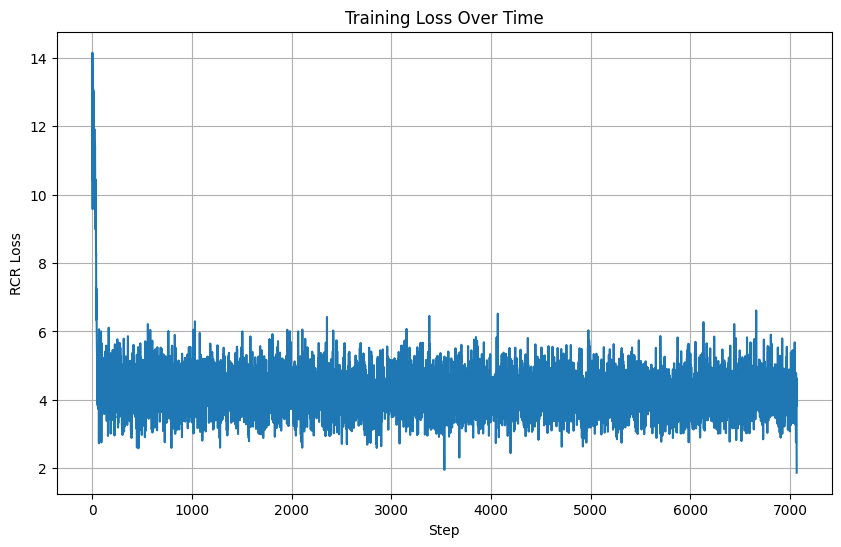

In [ ]:
## Plot training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Step')
plt.ylabel('RCR Loss')
plt.grid(True)
plt.show()

In [ ]:
## Evaluation

from sklearn.metrics import ndcg_score
from collections import defaultdict
import torch.nn.functional as F

model.eval()
query_to_scores = defaultdict(list)
query_to_labels = defaultdict(list)

test_pairs = test_dataset.pairs
test_labels = test_dataset.labels

batch_size = 32
with torch.no_grad():
    for i in tqdm(range(0, len(test_pairs), batch_size), desc="Evaluating"):
        batch_pairs = test_pairs[i:i+batch_size]
        batch_labels = test_labels[i:i+batch_size]

        queries = [q for q, _ in batch_pairs]
        products = [p for _, p in batch_pairs]

        encoded = tokenizer(
            queries,
            products,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        scores = torch.sigmoid(logits).cpu().tolist()

        for q, s, l in zip(queries, scores, batch_labels[i:i+batch_size]):
            query_to_scores[q].append(s)
            query_to_labels[q].append(l)

# Calculate average NDCG@10
ndcg_total = 0
count = 0

for q in prod_groups_test.keys():
    if sum(query_to_labels[q]) > 0:  # Only evaluate if there's at least one relevant item
        y_true = [query_to_labels[q]]
        y_score = [query_to_scores[q]]
        ndcg = ndcg_score(y_true, y_score, k=10)
        ndcg_total += ndcg
        count += 1

avg_ndcg_10 = ndcg_total / count if count > 0 else 0
print(f"Average NDCG@10: {avg_ndcg_10:.4f}")

Evaluating: 100%|██████████| 677/677 [03:50<00:00,  2.94it/s]

Average NDCG@10: 0.7570
